# Solving differential equations

This notebook aims at showing the use of the `DeSolver`.

In [1]:
# Necessary for dynamic plots
%matplotlib tk
import time
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import perceval as pcvl
import perceval.algorithm as algo
import perceval.algorithm.differentialEquationSolver as DES
import numpy as np
import sympy as sp

## Equations

The equation we are going to use in this example in pretty simple. This is the stationary Schrödinger equation for a massive particle in a 1D infinite energy box of size $L$: $- \frac{\hbar^2}{2 m} \frac{\partial^2}{\partial x^2} | \Psi \rangle = E | \Psi \rangle$. We are going to solve this supposing we have a real phase (which will not change the value of $E$, nor the shape of the result.)

As the solver takes into account only the first derivatives, we are going to transform this equation a bit by using two unknowns $Y = [| \Psi \rangle, \frac{\partial}{\partial x} | \Psi \rangle]$ noted $[y, z]$ for simplicity.

This gives us

\begin{gather*}
    y'= z\\
    - \frac{\hbar^2}{2 m} z' = E y \\
\end{gather*}

We impose the boundary conditions $y(0) = y(L) = 0$.

We can show that this gives us the analytical solution

\begin{gather*}
    | \Psi \rangle = C \sin(\frac{n \pi}{L}x) \\
    E_n = \frac{\hbar^2 \pi^2 n^2}{2 m L^2}
\end{gather*}
with $n \in \mathbb{N}^*$.

Since $| \Psi \rangle = 0$ is an unwanted solution for our system of equation, we will add the normalisation condition: $ \langle \Psi | \Psi \rangle = 1$. Our goal is only to find the form of the solution and the value of $E_1$, so there is no need that this is really fulfilled, but it should be enough to avoid null solutions. As the lowest energy solution is also the one that has the lowest frequencies, the solver should be able to find it without more equations. If we wanted to find a state of higher energy $E_n$, we could have added a penalisation equation or bounds to make sure the energy is higher than $E_{n-1}$, but it would require to know $E_{n-1}$.

In [2]:
# Renormalisation
L = 1
hbar = 1
m = 1

With this renormalisation, we expect to find $E_1 = \frac{\pi ^2}{2} \approx 4.935$.

In [3]:
theorical_E = hbar ** 2 * np.pi ** 2 / (2 * m * L ** 2)
print("target energy:", theorical_E)

target energy: 4.934802200544679


We are now going to declare all these equations as Perceval objects. The general declaration of any equation is done through the `Equation` that takes a Sympy expression, or str representing an expression. The variables names must be "u_i", "x", and "s_j" where i designates the curve number, and j the scalar number.

For each equation or boundary condition, we can specify a weight given to this equation to make it more important (although the importance is relative to each other weights). It can also be used to make comparable order of magnitude in all your equations (else, the low order of magnitude equations will almost be ignored). If the `Solver` struggles to find an appropriate solution, changing your weights can really improve convergence toward something good (however, this makes results impossible to compare through the loss value as it changes how changing weights changes how loss is calculated).

In case we want to solve complex systems, we need to define separately the real part and the imaginary part.

In [4]:
# First the differential equation system
n_out = 2
n_scalar = 1

x = sp.Symbol("x")
psi = sp.Function("u_0")(x)
psi_p_0 = sp.Function("u_1")(x)
psi_p_1 = sp.Derivative(psi)
psi_pp = sp.Derivative(psi_p_0)
psi_pp = sp.Derivative(psi, (x, 2))
E = sp.Symbol("s_0")

deriv = psi_p_0 - psi_p_1 # = 0
F = - hbar ** 2 / (2 * m) * psi_pp - E * psi
norm = sp.Integral(psi ** 2, (x, 0, L)) - 1


diff_eq = DES.Equation(F, weight=1)
diff_deriv = DES.Equation(deriv, weight=5)
eq_norm = DES.Equation(norm, weight=1000)

This is the general case to define a differential equation. As a rule of thumbs, always check that these objects return something when calling them on arrays, you don't want to compute for 5 minutes on QPU before having an error due to a wrongly written expression. In our case, if we want to use the same weight for our two main equations, since the equation system is linear, we could just use a matrix $A$ to define it, such that $Y' = AY$. In this case, we use a `LinearEquation`. Note that $A$ can contain Sympy expressions or str representing expressions.

In [5]:
# Equivalent definition for deriv and F
A = np.array([[0, 1],                                   # y' = 0 * y + 1 * z
              [- 2 * m * E / hbar ** 2, 0]])            # z' = (- 2 m E / hbar ** 2)y + 0z
de = DES.LinearEquation(A, weight=1)

Now to declare the boundary conditions, we have two choices: a general form `DifferentialEquation` where functions are evaluated at some points, and a more specific one `BCValue` that will specify which value must the function take at specific points. The `act_on_derivative` keyword can be used to impose the value on the function's derivative instead of the function. Again, Sympy expressions can be used. Be careful, if you want to use the value of a derivative at a given point, you must use the `subs` attribute of Sympy expressions, as Sympy functions are not directly callable.

In [6]:
boundary_0 = DES.Equation("u_0(0)")  # Can directly use str
boundary_0.weight = 20

# None means no restriction
boundary_L = DES.BCValue(L, [0, None], weight=20)

# We can also join the two boundary conditions into one, given they have the same weight
global_boundary = DES.Equation([psi.subs(x, 0), psi.subs(x, L)], weight=20)

Finally, we just have to gather our equations into a single `DECollection` object.

In [7]:
n_equations = 4
equation_names = ["eq", "deriv", "norm", "BC"]

des = (DES.DECollection(diff_eq)
       .add(diff_deriv)
       .add(eq_norm)
       .add(global_boundary))

Since we know the analytical solution, we can define it as a `AnalyticalSolution`. It will only be used for display to check that we reach the actual solution. In our case, the opposite of this solution may also be found, so we define it as a function, that allows us to define an outer scope trigger to change the sign for nicer plots. The downside of this method is that it requires us to work directly on arrays. Defining things as Python function can only be done for the analytical solution.

In [8]:
an = DES.AnalyticalSolution([(2 / L) ** .5 * sp.sin(sp.pi * x), (2 / L) ** .5 * sp.pi * sp.cos(sp.pi * x)])

opposite = False  # turn this to True to plot the negative analytical solution

def u(x):  # We have in fact 1/2 chance that the computed solution will be -u
    return an(x) * (-1 if opposite else 1)

## Paradigm shift

Sometimes, it could be better to rework from the equations to have something more simple. A good thing is to transform your differential equations into a set of integral equations, as integrals are far less sensitive to noise than derivatives.

With our example:

$- \frac{\hbar^2}{2 m} \frac{\partial^2}{\partial x^2} | \Psi \rangle = E | \Psi \rangle$ becomes $- \frac{\hbar^2}{2 m} y_{second} = E \iint y_{second} + c_0 x + c_1$, where $y_{second} = \frac{\partial^2}{\partial x^2} | \Psi \rangle$, and $c_0, c_1$ are integration constants.

Now, with the condition $| \Psi \rangle (0) = 0$, and knowing that the solver will impose $(\iint y_{second}) (0) = 0$, we obtain $c_1 = 0$, leaving us with only one unknown constant (the value at $0$ of the primitive of $y_{second}$).

In [ ]:
# Skip this part to use the previous system of equations

# First the differential equation system
n_out = 1
n_scalar = 2

x = sp.Symbol("x")
y_second = sp.Function("u_0")(x)
E = sp.Symbol("s_0")

# Note that here, the limits of the integral are not given, meaning we want the function and not a certain value.
# Value at x_min is always 0.
y = sp.Integral(sp.Integral(y_second, x) + sp.Symbol("s_1"), x)
integral = - hbar ** 2 / (2 * m) * y_second - E * y

diff_integral = DES.Equation(integral)
eq_norm_integral = DES.Equation(sp.Integral(y ** 2, (x, 0, L)) - 1, weight=100)

Now there is only one boundary condition left, at $x = L$, as the one at $x = 0$ is enforced by our solving process.

In [ ]:
bc_integral = DES.Equation(y.subs(x, L), weight=2)

Finally, we do as before.

In [ ]:
n_equations = 3
equation_names = ["eq", "norm", "BC"]

des = (DES.DECollection(diff_integral)
       .add(eq_norm_integral)
       .add(bc_integral))

In [ ]:
# If we force the derivative of psi at 0 to be positive, we will always end with the positive solution
u = DES.AnalyticalSolution(- (2 / L) ** .5 * sp.pi ** 2 * sp.sin(sp.pi * x))  # with pi ** 2 as we work on the second derivative

## Computing

We now have to declare how we want to compute the solution to the equation. Basically, we must start by declaring a `RemoteProcessor`. There are two ways to declare a working `RemoteProcessor`. Either we specify a detection scheme, so it precomputes things at first iteration to make computation faster, but it can work only with perfect simulators, either we use a specific format (see [below](#Just-a-few-notes-about-ProcessorComputers)) of processors that can handle any processor, but does not have optimisation.

For a first attempt, we are going to use the first kind of processor with Pseudo number resolving (PNR), which uses threshold detection but with supplementary beam splitters at the end of the circuit that will try to separate the photons before their detection, maximising the received information.

In [9]:
modes = 6  # number of modes before the final beam splitters
n = 2  # number of photons
token = "YOUR_TOKEN"
processor = pcvl.RemoteProcessor("sim:clifford", token)
processor.set_parameter("scheme", "pseudo_PNR")  # The scheme field declares that this processor is of the first kind

c = pcvl.Unitary(pcvl.Matrix.random_unitary(modes))
for i in range(modes):
    c = c.add(i, pcvl.PS(pcvl.P(f"{i+1}x")))
c = c.add(0, pcvl.Unitary(pcvl.Matrix.random_unitary(modes)))
processor.set_circuit(c)

processor.with_input(pcvl.BasicState([1] * n + (modes - n) * [0]))
pcvl.pdisplay(processor)

Note that the final beam splitters are not displayed as they are not computed by Perceval but added at the end of the computation.
Some computation parameters can be set with `set_parameters`, with the other parameters the Processor can take.

In [10]:
processor.set_parameters({
    "phase_imprecision": 1e-3,  # Imprecision on the PS phases
    "samples": 2e5,  # Number of samples at each point of the grid
    "photon_loss": .9  # Probability to lose a photon before detection. Similar to LC components, but precomputed
})

## Solving

To solve these equations, we need to know where to solve them. Obviously, the points given at the boundary conditions must be included in the interval covered by this grid.

In [11]:
n_grid = 50

X = np.linspace(0, L, n_grid)  # An evenly spaced grid is not mandatory

We now have everything to solve the equations. Let's declare a `DESolver` instance with all these equations. There are many options on the solver, such as initial bounds of the solution (be careful, it can be crossed during the optimisation), the number of unknown scalars, their bounds, and a penalisation factor to reduce the noise due to sampling (warning: this changes the loss function, making you solve a slightly different differential equation). Here, we physically know that $E$ will be non-negative, and we can guess its value will not be too high since all our constants are 1. Once again, pay attention to the bounds, as they will highly impact the convergence towards something good (here, using (0, 100) doesn't give good results due to initial guess).

In [12]:
solver = algo.DESolver(X, des, processor, scalar_bound=[(0, 10), (0, 20)][:n_scalar], force_scalar_bounds=True)

As for processors, we can give parameters to the solver, but that are linked to the solving process itself.

In [13]:
# Will recompute the probabilities every n iterations. default is 0, meaning no re-computation. Useful to make it learn to avoid noise
solver.set_parameter("resampling_it_number", 0)
# noise_filter frequency used on the solution curves. Higher values mean less noise reduction
solver.set_parameters({
    "nf_frequency": .15,
    "nf_order": 2
})

We can also give some useful information to the solver, that will be exclusively used for monitoring. Any function can be used as callback, provided it takes these arguments.

In [14]:
solver.analytical_solution = u
solver.legend = [r"$| \Psi \rangle$", r"$\frac{\partial}{\partial x} | \Psi \rangle$"] if n_out == 2 else \
                [r"$\frac{\partial^2}{\partial x^2} | \Psi \rangle$"] # default is [0, 1]
solver.scalar_legend = ["$E$", None][:n_scalar]  # None means no display

def pbar(q):  # Needed as tqdm will display in the cell it has been declared and not in the running cell
    start = time.time()
    def callback(res):
        results = res["results"]
        q.set_description("Loss: %0.5f elapsed: %0.5f" % (results["loss_evolution"][-1],
                                                          results["time"][-1] - (results["time"][-2] if len(results["time"]) > 1 else start)
                                                          ))
        q.update(results["iteration_count"] - q.n)

    return callback

We can now run the solver. Use the `display_job` to monitor the solving process. Be aware that according to the matplotlib magic that you use, it is possible that only the result is only shown at the end.

The displayed loss represents how far from having all the differential equations and boundary conditions solved on each point the solution is. The closer to 0, the better the approximation.

In [15]:
q = tqdm()
solver.pbar = pbar(q)  # if exists, must be a tqdm object, but can be adapted to your environment (notebook, terminal, ide...)
job = solver.solve.execute_async()
while not job.is_complete:
    time.sleep(1)
    solver.display_job(job, display_curve = True)
q.close()

0it [00:00, ?it/s]

KeyboardInterrupt: 

If the loss is too big, you can perform the computation several times. Adding the results to `solver.results` will allow it to perform further computation and plotting. As the results are only composed of Python's native objects and Numpy arrays, they can also easily be saved.

In [18]:
q = tqdm()
solver.pbar = pbar(q)
for _ in range(20):
    q.reset()
    job = solver.solve.execute_async()
    while not job.is_complete:
        time.sleep(1)
        solver.display_job(job)
    print("Energy found:", solver.results[-1]["results"]["scalars"][0], "corresponding loss:", solver.results[-1]["results"]["final_loss"])
    q.leave = True
q.close()

0it [00:00, ?it/s]

Energy found: 4.872152814304573 corresponding loss: 3.9717223159966144
Energy found: 3.8351324200104577 corresponding loss: 4.622681389994862
Energy found: 4.5850828427976085 corresponding loss: 3.646609248903439
Energy found: 4.315384286494077 corresponding loss: 10.835722441558584
Energy found: 4.115343563383202 corresponding loss: 4.073258091094957
Energy found: 4.666326233314379 corresponding loss: 4.290207370614583
Energy found: 0.000509241402041043 corresponding loss: 9.961685009527145
Energy found: 4.920672241300555 corresponding loss: 4.148796770565229
Energy found: 4.509207463006803 corresponding loss: 3.601259029749654
Energy found: 3.4517669045573345 corresponding loss: 4.57847224812199
Energy found: 3.303861994810354 corresponding loss: 4.609709075209524
Energy found: 0.0 corresponding loss: 9.936131428800959
Energy found: 4.883574210741985 corresponding loss: 3.6361816780292036
Energy found: 3.2003252930276203 corresponding loss: 4.51330857085999
Energy found: 4.3964003402

In [16]:
print(solver.results[-1])

{'unitary_parameters': array([ 1.87683231,  1.38714662, -0.70835325,  3.16361399, -1.01907451,
        1.3966882 ,  0.69945548, -0.86523352,  1.43426045,  0.16760758,
       -0.55772388,  0.47608923, -0.17789769, -1.02317626, -0.45056305,
        0.12705946,  0.61842582,  0.78034901, -0.4557833 ,  0.42652564,
        0.54687209,  1.81899609,  0.21436469,  1.55194193, -0.05999294,
       -0.35599298, -0.19401986,  0.01481952,  2.83036466,  1.25473429,
        0.60555296, -1.26128999,  1.15643831,  0.24320321, -0.13444436,
        1.73615142,  1.84390783, -0.08511496,  0.27860252,  0.55463204,
        0.59074085, -0.20966519, -0.16114074,  0.7151254 , -1.89117065,
       -0.20690247,  2.34728393, -0.9980569 ,  0.78467368, -0.23484706,
        0.18548112, -1.64179017, -1.09933049, -0.35359836,  2.08717753,
       -0.9589047 ,  0.64532924, -0.77722639,  0.97960603,  1.63576184,
        0.94797855, -0.86994432, -0.48334342,  1.12470742, -0.11444592,
       -0.52147621,  0.88204542, -0.21009

We can see that the closer we are to the good value of $E$, the lesser is the loss. Thus, keeping the best solution we found should give us a good approximation of $E$.

If we want to obtain an already optimised solution, we can use the `retrieve_solution` with the index of the solution we want. Using `recompute = True`, we can ask to recompute the probabilities and thus the curve (with a different sampling noise). If the grid has changed but `recompute = False`, it will perform an interpolation to match the new grid. With `store_new`, you can ask to keep the result in `solver.result`. The originally computed function (right after the optimisation) can be restored in the `solver.results` field using `restore_original`.

In [ ]:
points = n_grid * 2
solver.X = np.linspace(0, L, points)

i = 0  # First solution
recompute = False  # to recompute the curves. This will add random noise again in case of sampling.
Y = solver.retrieve_solution(i, recompute=recompute)  # This is a synchronous job
print(len(Y), points)

It is of course possible to plot the approximations. The grid can be changed, provided it keeps the same border values. In such a case, the curves will be computed again to fit the new grid. Too many points will however lead to more sampling noise. Many parameters can be given to the plot function, for example to select some specific solutions (`plot_solutions` must be set to True for this to work). The scalar values of the best solution will be set as title.

In [17]:
# If the grid has changed, solutions can be recomputed using recompute. Else, their former grid will be used to plot them.
# With plot_solutions = True, all solutions will be plotted. Else, only the best solution will be plotted.
solver.plot(plot_solutions=False, recompute=recompute)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Prob. ampli. density")
plt.show();

There is another interest to computing several solutions. The solver comes with a post optimisation method that will try to find the best linear combination from the different solutions. It can be directly performed in the plot function if it has not been performed before, using only the selected solutions. The post optimisation result will be saved in `solver.post_optimisation_result`. If there are few solutions, or the solutions already give excellent results, the post-optimised solution can be farther than the best computed solution. However, most of the time, the post-optimised solution is better, less sensitive to sampling noise. Here, we select only the solutions with positive values (just because we can) but we do not want to avoid solutions in the post-optimisation process, so we compute post-optimisation before. We choose to plot only $| \Psi \rangle$ with `curve_indexes`.

This time, as we asked to plot the post-optimised solution, the scalar values of the post-optimised solutions will be used as title, and not the ones of the best solution.

In [18]:
# Can also be used with only one solution, but do not expect a huge improvement in such a case.
solver.post_optimisation()
fig, axs = plt.subplots(1, 2)
solver.plot(best_solution=False, post_optimised=True, post_selection_fn=lambda sol: sol["function"][n_grid // 2, 0] > 0, curve_indexes=[0], where_to_plot=axs[0])
solver.plot(post_optimised=False, curve_indexes=[0], where_to_plot=axs[1])
for ax in axs:
    ax.legend()
    ax.set_xlabel("Distance")
    ax.set_ylabel("Prob. ampli. density")
plt.show();

In [19]:
best_sol = min(solver.results, key=lambda sol: sol["results"]["final_loss"])
print("best non-optimised loss:", best_sol["results"]["final_loss"])
print("post-optimised loss:", solver.post_optimisation_result["final_loss"])

best non-optimised loss: 3.9493140395952833
post-optimised loss: 3.9493135140032436


In both cases, we find a rather good approximation of $E$.

In [ ]:
print("relative error on E (raw):", abs((best_sol["results"]["scalars"][0] - theorical_E) / theorical_E))
print("relative error on E (post-optimised):", abs((solver.post_optimisation_result["scalars"][0] - theorical_E) / theorical_E))

If we used a transformation not solving directly on the solution, we can use a `ResultPostProcess` to directly act on the solution. and retrieve the wanted function.

In [ ]:
# Only if we worked on the second derivative
if n_equations == 3:
    post_process = DES.ResultPostProcess(y)  # y is the expression of the double integral
    new_u = DES.AnalyticalSolution((2 / L) ** .5 * sp.sin(sp.pi * x))  # This time it's |Psi>

    X = best_sol["X"]
    Y = best_sol["results"]["function"]
    scalars = best_sol["results"]["scalars"]

    plt.plot(X, post_process(Y, X, scalars), label=r"$| \Psi \rangle$")
    plt.plot(X, new_u(X), "k--", label="Analytical solution")
    plt.legend()
    plt.show()

We can see that despite having a rather noisy second derivative, the first derivative is smooth and follows the analytical solution very well.

We can also check how much loss each equation of our system of equation gives. This bar chart can be important to tune the weights of the equations if we want a better precision.

In [ ]:
X = solver.post_optimisation_result["X"]
Y = solver.post_optimisation_result["function"]
scalars = solver.post_optimisation_result["scalars"]

plt.bar(range(n_equations), des.compute_all_losses(Y, X, scalars))
plt.xticks(range(n_equations), labels = equation_names)
plt.title("loss per equation")
plt.show()

## Just a few notes about Processor schemes

As said before, any processor can be used to perform computation. However, they must fulfill some requirements in their structure.

The most important thing is that they **must** have parameters with a name of the form "coeffx". When a grid value is given to the processor, it will first be linearly changed to be in the interval $[0, phase_{max}]$, then every parameter with the form "coeffx" will be given the value $coeff * x$. If the parameter's name is just "x", then it will be evaluated as if $coeff$ is 1. By default, $phase_{max}$ is $\pi$. If all the coefficients are integers and on $t$ periodic variables, then setting $phase_{max}$ to $t$ will ensure that the solution is periodic (e.g. for phase shifters with $coeff = 1$, $t = 2 \pi$).

For other parameters, a random value will be given to this parameter, then the solver will alternate between optimising changing the weights and changing the parameters. Since it will compute an estimation of the gradient of the loss, it is not advised to use many parameters, as it requires a lot of samples to efficiently compute the gradient, unless you are using a simulator with no sampling.

The processor below is a valid computer with several coefficients, allowing to use different values for the parameters. Of course, the same parameter can be used at different places as in any circuit.

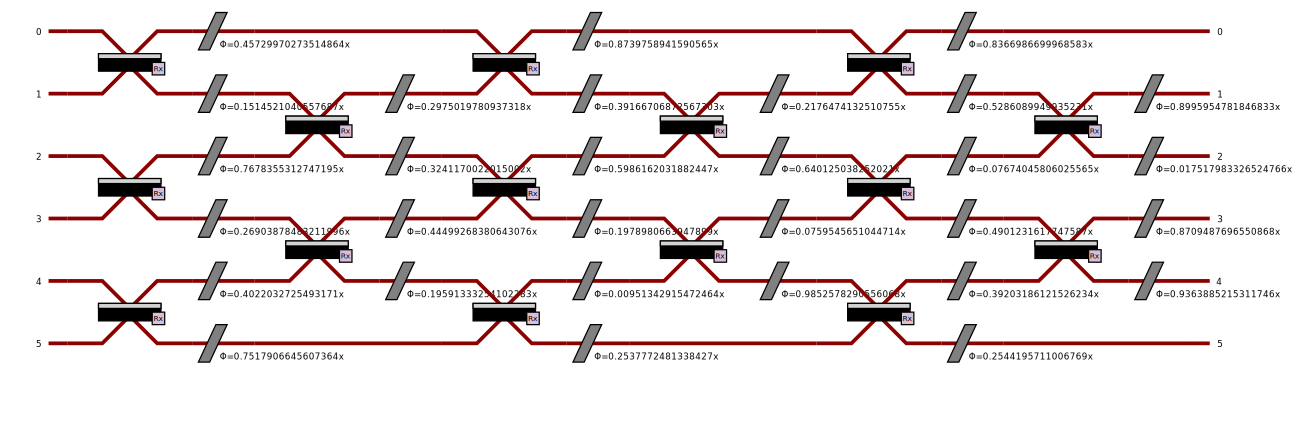

In [22]:
modes = 6
n = 1

c = pcvl.Circuit.generic_interferometer(modes, lambda i: (pcvl.BS()
                                                          .add(1, pcvl.PS(pcvl.P(f"{random.random()}x")))
                                                          .add(0, pcvl.PS(pcvl.P(f"{random.random()}x")))
                                                          ))

pcvl.pdisplay(c)

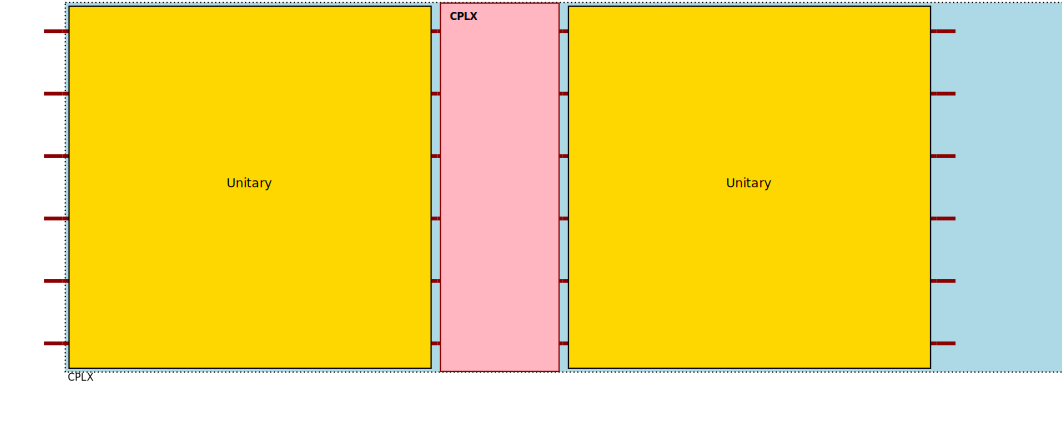

In [23]:
c = pcvl.Unitary(pcvl.Matrix.random_unitary(modes)) // c // pcvl.Unitary(pcvl.Matrix.random_unitary(modes))

proc = pcvl.Processor("sim:clifford", token)
proc.with_input(pcvl.BasicState([1] * n + [0] * (modes - n)))
proc.mode_post_selection(n)
proc.thresholded_output(True)

pcvl.pdisplay(proc, recursive=True)

The value of x can be changed before being multiplied by $coeff$ by setting to `param_preprocessing` a `ProcessX` function, and after this multiplication by setting a `param_postprocessing` function.

In [24]:
proc.set_parameters({
    "grid_phase_max": 1,  # Needed to make sure we stay in the domain of definition of arccos
    "grid_preprocessing": DES.ProcessX("arccos(x)"),
    "grid_postprocessing": DES.ProcessX("x ** 2 + 1"),
    "brightness": .02,  # Imperfect source
    "purity": .98,
    "indistinguishability": .9,
    "imprecision": 1e-3
})

We can now run again the [Solving](#Solving) part of this notebook to use this new computer.

In case we want to use a pre-created scheme using the parameter field `scheme`, here is a description of the different schemes and the parameters.

'scheme' can be
- "NR": probabilities are computed as the result of the circuit, as if used on a Processor.
- "threshold": simulates thresholded states (as if the Processor had Processor.thresholded(True))
- "pseudo_PNR": mimic threshold detectors but with additional beam splitters at the end of the circuit to try to separate the photons.
- "post_selection": same as pseudo_PNR, but only states having photons on the same number of modes than the number of requested photons are kept.

Using a scheme value will allow to use more computation parameters:
- "photon_loss": simulates loss of photons at the end of the circuit. Equivalent to loss channels.
- "emission_probability": source emission_probability.
- "multiphoton_component": source g2.
- "indistinguishability": source indistinguishability.